# Part I - Bike Sharing Exploration
## by Austin Jex

## Introduction

## Preliminary Wrangling

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import matplotlib.colors as mcolors
import matplotlib.cm as cm


In [4]:
bike_df = pd.read_csv('201902-fordgobike-tripdata.csv')

### What is the structure of your dataset?

In [ ]:
bike_df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [ ]:
bike_df.shape

(183412, 16)

The dataset contains 183,412 rows of bike rental data, with 16 elements per record.

### What is/are the main feature(s) of interest in your dataset?

I am interested in ride duration, start time, end time, start station latitiude and longitude, end station latitiude and longitude, member gender, and member birth year.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I think that in order to investigate any features in any dataset, the features themselves are essential, for without said features, there is nothing to investigate. Thus, my investigation of features in this dataset will be greatly helped by the presense, rather than absence, of the features which I hope to investigate. I can't imagine how else I'd hope to investigate these features, if the features themselves were absent. 

## Univariate Exploration

> In this section, investigate distributions of individual variables. If you see unusual points or outliers, take a deeper look to clean things up and prepare yourself to look at relationships between variables.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

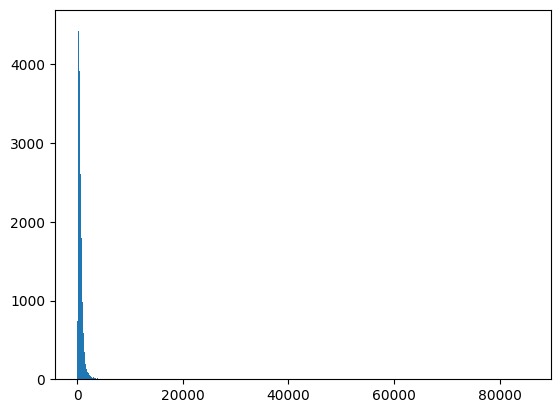

In [ ]:
plt.hist(bike_df['duration_sec'], bins='auto')
plt.show()

It appears there are some extreme outliers. Almost all the data is below 5,000 seconds of ride duration. I will investigate the outliers. First, I will get some descriptive statistics about the distribution of durations.

In [ ]:
print(bike_df['duration_sec'].describe())

count    183412.000000
mean        726.078435
std        1794.389780
min          61.000000
25%         325.000000
50%         514.000000
75%         796.000000
max       85444.000000
Name: duration_sec, dtype: float64


Outliers are typically considered values which are more than 3 standard deviations from the mean (Z-score > 3). That means that outliers in this dataset would be rides whose duration exceeds:

>**(726.08 + (3 * 1794.39) = 6,109.25 **

An appropriate outlier threshhold for this distribution (according to the Z > 3 rule) is 6,109.25 seconds. How many records exceed this value?

In [5]:
#Count of rides above 6,109.25 seconds (1.7 hours) duration 
(bike_df['duration_sec'] > 6109.25).sum()

np.int64(888)

In [ ]:
#What percent of the records qualify as outliers?
percent_outliers = (888/183412) * 100
percent_outliers

0.4841558894728808

888 records qualify as outliers according to the Z > 3 rule of thumb. 
These represent 0.48% of the records. I will consider these to be outliers for the purpose of this project.

In [7]:
#I will update the DataFrame to exclude outliers
bike_updated = bike_df[(bike_df['duration_sec'] <= 6109.25)]

In [10]:
bike_updated.shape

(182524, 16)

The outliers were successfully removed. I will re-plot the histogram to show the updated durations (with outliers excluded).

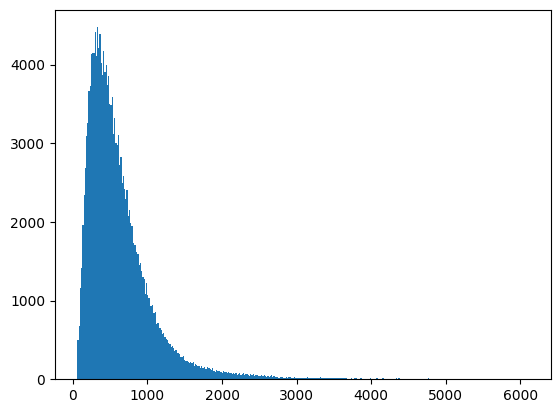

In [11]:
plt.hist(bike_updated['duration_sec'], bins='auto')
plt.show()

This histogram is much more informative than the previous one, now that the range has been narrowed to exclude outliers.

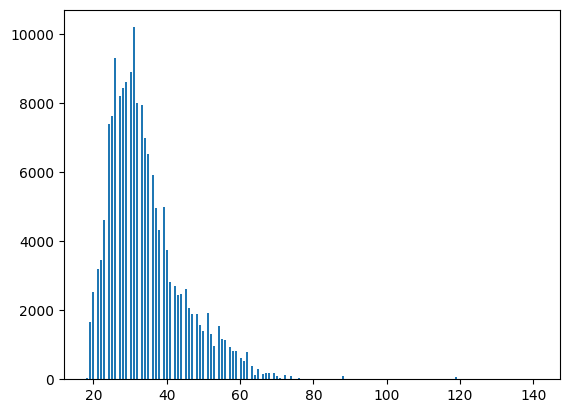

In [12]:
#Now let's look at member ages
plt.hist((2019 - bike_updated['member_birth_year']), bins = 'auto')
plt.show()

It appears we have at least one outlier in this datset near 119 years of age. It's unlikely the world's oldest living person is renting bikes. Let's see what the cuttoff for outliers is in this distribution:

In [13]:
(2019 - bike_updated['member_birth_year']).describe()

count    174461.000000
mean         34.188844
std          10.115881
min          18.000000
25%          27.000000
50%          32.000000
75%          39.000000
max         141.000000
Name: member_birth_year, dtype: float64

There's even a 141 year-old I didn't detect on the histogram! Let's find out how many member ages have a Z-score above 3.

> 34.19 + (3 * 10.16) = 64.67

Looking at the distribution, it doesn't seem to me that Z > 3 is an appropriate outlier threshhold, seeing as there are plenty of 65+ year-olds in the histogram that don't appear to be outliers. I think a more appropriate method for determining outliers in this case might be to select an age by my own judgement. Looking at the histogram, and using reason, it seems users over 99-years-old are outliers. I will check how many users' birth year is before 1920 before concluding this decision:

In [14]:
#Count of members born before 1920 (age > 99)
(bike_updated['member_birth_year'] < 1920).sum()

np.int64(72)

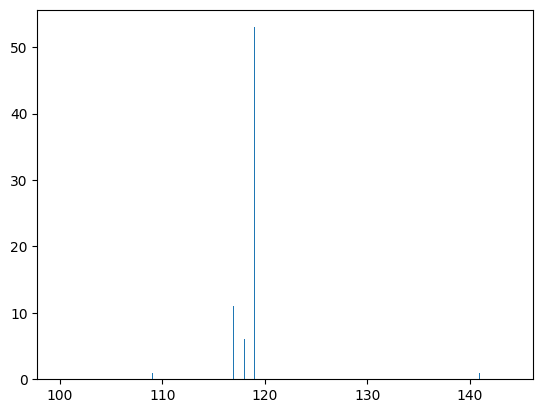

In [15]:
plt.hist((2019 - bike_updated['member_birth_year']), bins = 'auto', range = (100, 144))
plt.show()

The cluster of birth years near 1900 (119 years-old in 2019) seems like an obvious indicator of users entering an absurb and untrue birth year. It seems appropriate to exclude all records whose birth year is less than 1920.

In [16]:
#Find number of rows where member age exceeds 99
bike_100_plus = bike_updated[(bike_updated['member_birth_year'] < 1920)]

In [17]:
bike_100_plus.shape

(72, 16)

In [8]:
#Update the DataFrame to exclude members who are 100 and older 
bike_updated_df = bike_updated[(bike_updated['member_birth_year'] > 1919) | (bike_updated['member_birth_year'].isna())]

In [19]:
bike_updated_df.shape

(182452, 16)

The 72 records where member birth year < 1920 were excluded from this new DataFrame.

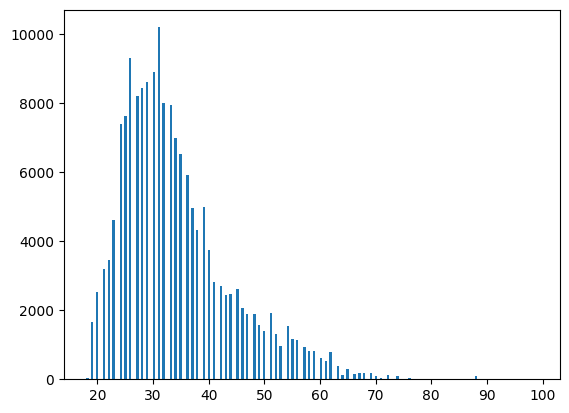

In [17]:
#Re-plotting the age histogram now that outliers were excluded
plt.hist((2019 - bike_updated_df['member_birth_year']), bins = 'auto')
plt.show()

Next, I want to explore the longitudinal and latitudinal data for range and outliers.

In [9]:
#I will make a DataFrame that groups by Start Station
stations = bike_updated_df.groupby('start_station_name').agg({
    'duration_sec': 'mean',
    'start_station_latitude': 'mean',
    'start_station_longitude': 'mean'
}).reset_index()

In [32]:
# Create a Folium map centered on the mean location of all points
m = folium.Map(
    location=[stations["start_station_latitude"].mean(), 
              stations["start_station_longitude"].mean()], 
    zoom_start=10,
    width=800,  
    height=800,
    tiles="CartoDB positron"
)

# Add circle markers for each row in the dataframe
for _, row in stations.iterrows():
    folium.CircleMarker(
        location=[row["start_station_latitude"], row["start_station_longitude"]],
        radius=3,  # Size of the circle
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.6
    ).add_to(m)

# Show the map
m

The range of latitudes and longitudes seem appropriate. I cannot detect any outliers on errors in these geospatial variables. All the stations appear to be clustered around San Francisco, San Jose, and Oakland in an expected way. None of the stations seem out of place for what I'd expect in a bike sharing dataset like this one.

Lastly, I will look at gender.

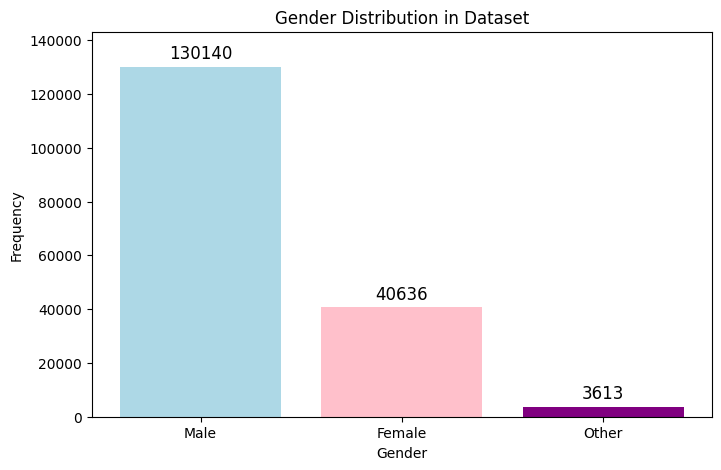

In [23]:
#Get count of each gender category (ignoring null values)
gender_counts = bike_updated_df['member_gender'].value_counts()
#Plot the counts of each gender category using a bar plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(gender_counts.index, gender_counts.values, color=['lightblue', 'pink', 'purple'])
ax.bar_label(bars, labels=gender_counts.values, padding=3, fontsize=12)
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.title("Gender Distribution in Dataset")
ax.set_ylim(0, gender_counts.max() * 1.1)  # Extends y-axis by 10% so label doesn't overlap with line
plt.show()

This bar chart is helpful to see the frequency of member genders in the dataset. Barring records where gender is null, the following are the frequencies of gender in the dataset:

In [24]:
#Percent of members who are male
130140 / (130140 + 40636 + 3613) * 100

74.6262665649783

In [25]:
#Percent of members who are female
40636 / (130140 + 40636 + 3613) * 100

23.301928447321792

In [26]:
#Percent of members who are another gender
3613 / (130140 + 40636 + 3613) * 100

2.0718049876999123


### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> I encountered some unexpected ride durations. I decided to exclude records from the DataFrame where duration had a Z-score > 3. I did this so that correlations weren't skewed by some extreme outliers. 

> I encountered some unreasonable member birth years. I decided to exclude records where age (2019 - birth year) exceeded 99 years. I made this exclusion so that correlations were not skewed by some outliers.


## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your data. Make sure the variables that you cover here have been introduced in some fashion in the previous section (univariate exploration).

> **Rubric Tip**: This part (Bivariate Exploration) should include at least one scatter plot, one box plot, and at least one clustered bar chart or heat map.

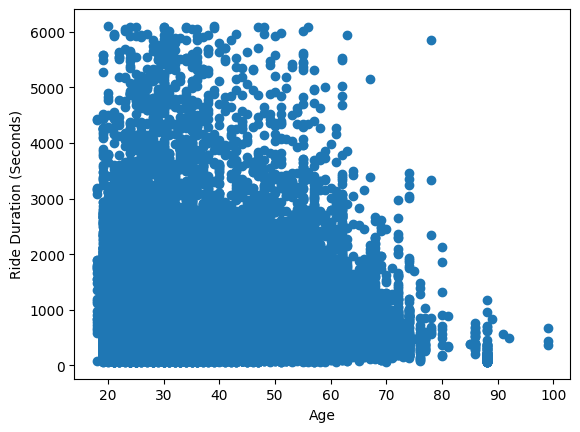

In [39]:
#Scatterplot of age and ride duration
yaxis = bike_updated_df['duration_sec']
xaxis = (2019 - bike_updated_df['member_birth_year'])
plt.xlabel("Age")
plt.ylabel("Ride Duration (Seconds)")
plt.scatter(xaxis, yaxis)

plt.show()

<Axes: >

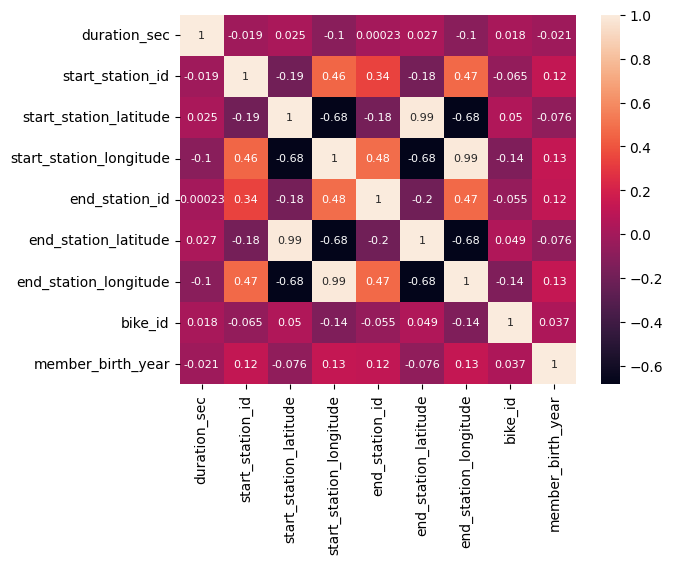

In [31]:
#Correlation Heatmap
sns.heatmap(bike_updated_df.corr(numeric_only = True), annot=True, annot_kws={"size": 8})

Looking at the actual correlation coefficients revealed an insight which the histogram of age and duration made unclear:

The histogram appears to show a possibly neagative correlation between age and ride duration.

In reality, the correlation coefficient is almost exactly zero, erring on the side of positive by a hair (0.021). The correlation matrix made this much more clear than looking only at the histogram. The histogram is misleading simply due to the massive quantity of points which form a blob on the graph, and the only shape we can see exists in the longest rides. It might be said that extrememly long rides are had by younger riders, but on the whole, there is no correlation between rider age and ride duration. 

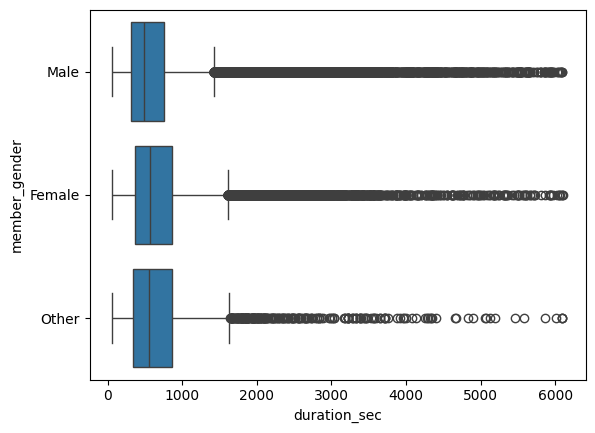

In [36]:
sns.boxplot(data=bike_updated_df, y='member_gender', x='duration_sec', color='tab:blue')
plt.show()

Members whose gender is female or other had slightly longer ride durations on average than members whose gender was male.

I'd now like to look at which starting stations had the longest (and shortest) ride durations. I'm going to use a blue (short) to orange (long) color spectrum to represent average ride length.

In [11]:
# Normalize 'duration_sec' to a color scale (340 to 2000 seconds → orange to blue)
norm = mcolors.Normalize(vmin=340, vmax=2000)
colormap = cm.ScalarMappable(norm=norm, cmap="coolwarm_r")  

# Create a Folium map centered on the mean location
m = folium.Map(
    location=[stations["start_station_latitude"].mean(), 
              stations["start_station_longitude"].mean()], 
    zoom_start=10,
    width=800,  
    height=800,
    tiles="CartoDB positron"
)

# Add circle markers, colored by 'duration_sec'
for _, row in stations.iterrows():
    duration = row["duration_sec"]
    color = mcolors.to_hex(colormap.to_rgba(duration))  
    
    folium.CircleMarker(
        location=[row["start_station_latitude"], row["start_station_longitude"]],
        radius=4,  
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
    ).add_to(m)

# Add a legend
colormap = folium.LinearColormap(["orange", "blue"], vmin=340, vmax=2000, caption="Ride Duration (seconds)")
m.add_child(colormap)

# Show the map
m


### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> There is surprisingly no relationship between age and ride duration.

> Males have slightly shorter average ride durations than females and other genders.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> I was able to map the average ride duration of each start station. The findings here are really more insightful by exploring the above map than by me recapping any particular numbers. If anything might be of note, it seems there could be a relationship between the average rid duration and the distance of a start station to other stations, although I would have to conduct further research to know that correlation does, in fact, exist.

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

In [8]:
#Making a column called Age to make it easier to use this variable going forward
bike_updated_df = bike_updated_df.copy()
bike_updated_df['Age'] = 2019 - bike_updated_df['member_birth_year']

In [9]:
bike_updated_df.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,Age
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes,45.0
5,1793,2019-02-28 23:49:58.6320,2019-03-01 00:19:51.7600,93.0,4th St at Mission Bay Blvd S,37.770407,-122.391198,323.0,Broadway at Kearny,37.798014,-122.405950,5200,Subscriber,1959.0,Male,No,60.0
6,1147,2019-02-28 23:55:35.1040,2019-03-01 00:14:42.5880,300.0,Palm St at Willow St,37.317298,-121.884995,312.0,San Jose Diridon Station,37.329732,-121.901782,3803,Subscriber,1983.0,Female,No,36.0
7,1615,2019-02-28 23:41:06.7660,2019-03-01 00:08:02.7560,10.0,Washington St at Kearny St,37.795393,-122.404770,127.0,Valencia St at 21st St,37.756708,-122.421025,6329,Subscriber,1989.0,Male,No,30.0
8,1570,2019-02-28 23:41:48.7900,2019-03-01 00:07:59.7150,10.0,Washington St at Kearny St,37.795393,-122.404770,127.0,Valencia St at 21st St,37.756708,-122.421025,6548,Subscriber,1988.0,Other,No,31.0


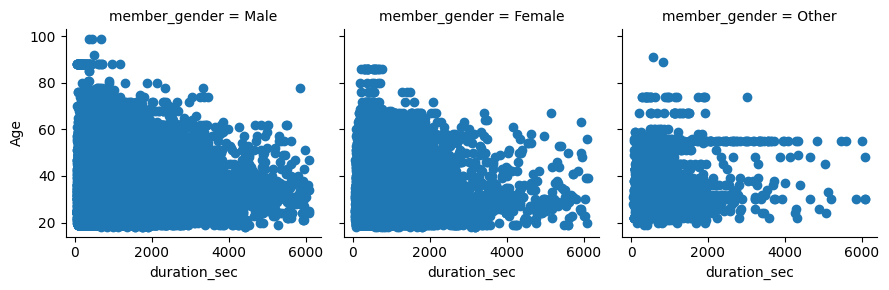

In [29]:
# Faceted Scatterplot od duration by age, faceted by gender
g = sns.FacetGrid(data=bike_updated_df, col='member_gender')
g.map(plt.scatter, 'duration_sec','Age')
plt.show()

In [28]:
#I will also find the correlation coefficient (r) for these graphs, faceted by gender
for gender, subset in bike_updated_df.groupby('member_gender'):
    x = subset['duration_sec'].dropna()
    y = subset['Age'].dropna()
    if len(x) > 1 and len(y) > 1:
        r, _ = pearsonr(x, y)
        print(f"Correlation for {gender}: r = {r:.2f}")

Correlation for Female: r = -0.01
Correlation for Male: r = 0.03
Correlation for Other: r = 0.09


In [14]:
# Count the number of rides per start station
station_counts = bike_updated_df.groupby("start_station_name").size().reset_index(name="ride_count")

In [15]:
# Merge the ride count back into statitions DataFrame
stations_updated = stations.merge(station_counts, on="start_station_name", how="left")

In [13]:
stations_updated.head()

,start_station_name,duration_sec,start_station_latitude,start_station_longitude,ride_count
0,10th Ave at E 15th St,872.508772,37.792714,-122.248780,57
1,10th St at Fallon St,702.376437,37.797673,-122.262997,348
2,10th St at University Ave,816.678947,37.869060,-122.293400,190
3,11th St at Bryant St,561.312802,37.770030,-122.411726,828
4,11th St at Natoma St,588.643519,37.773507,-122.416040,864


In [16]:
#Adding a relative size variable based on ride count
stations_updated["normalized_size"] = stations_updated["ride_count"] / stations_updated["ride_count"].max() * 20

In [17]:
#Plotting stations by average ride duration (color dimension) and relative ride count (size dimension)
# Normalize 'duration_sec' to a color scale (340 to 2000 seconds → orange to blue)
norm = mcolors.Normalize(vmin=340, vmax=2000)
colormap = cm.ScalarMappable(norm=norm, cmap="coolwarm_r")  

# Create a Folium map centered on the mean location
m = folium.Map(
    location=[stations_updated["start_station_latitude"].mean(), 
              stations_updated["start_station_longitude"].mean()], 
    zoom_start=10,
    width=800,  
    height=800,
    tiles="CartoDB positron"
)

# Add circle markers, colored by 'duration_sec'
for _, row in stations_updated.iterrows():
    duration = row["duration_sec"]
    color = mcolors.to_hex(colormap.to_rgba(duration))  # Convert color to hex
    size = (row["normalized_size"])
    folium.CircleMarker(
        location=[row["start_station_latitude"], row["start_station_longitude"]],
        radius=size, 
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
    ).add_to(m)

# Add a legend
colormap = folium.LinearColormap(["orange", "blue"], vmin=340, vmax=2000, caption="Ride Duration (seconds)")
m.add_child(colormap)

# Show the map
m

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

>Based on these faceted scatterplots and correlation coefficients, it appears that member gender does not signifficantly change the correlation coefficent of age and ride duration. All of the correlation coefficients are negligible. 

>When looking at the scattermap of ride count and duration by starting station, it is interesting to observe how the location of stations in San Francisco relates to average ride duration and ride count. It seems that stations that are more central in San Fransisco have significantly higher ride count and significant lower ride duration than start stations on the outskirts of the city. 

### Were there any interesting or surprising interactions between features?

> None of the relationships seemed very surprising. I find the map findings to be very interesting, but not surprising. It seems intuitive that stations in the center of a city will get a lot more use than ones on the outskirts. It also makes sense that start stations which are far from city center might have longer ride durations (people have a tendency to bike to city center most likely).

## Conclusions
Whether for the entire dataset as a whole, or whether faceted by gender, the relationship between member age and ride duration is negligible (no relationship). 

Start stations near the center of a city tend to have higher ride count and lower ride duration, compared to start stations on the outskirt of the city. 